# Applied Capstone Project - IBM DataScience
###  By S, Dharshan

This Article/NoteBook is part of IBM Datascience capstone project. In previous examples we saw how data science was used to cluster neigbourhoods in newyork toronto. Today we are going to see neighbourhood clusters(Called Zones) and see which place is suitable to open an Restaurant and also see what type of restaurant is prefered in the city.

To checkout the code at GitHub , click Here 


## Introduction
Chennai AKA Madras (the official name until 1996), is the capital of the Indian state of Tamil Nadu. Located on the Coromandel Coast off the Bay of Bengal, it is one of the largest cultural, economic and educational centres of south India. According to the 2011 Indian census, it is the sixth-most populous city and fourth-most populous urban agglomeration in India. The city together with the adjoining regions constitutes the Chennai Metropolitan Area, which is the 36th-largest urban area by population in the world.

### Greate tourist attraction
The traditional and de facto gateway of South India, Chennai is among the most-visited Indian cities by foreign tourists. It was ranked the 43rd-most visited city in the world for the year 2015. The Quality of Living Survey rated Chennai as the safest city in India. Chennai attracts 45 percent of health tourists visiting India, and 30 to 40 percent of domestic health tourists.As such, it is termed "India's health capital".Chennai has the fifth-largest urban economy of India. This gives us additional reasons to open restauratants in this great city


### Problem Statement
Opening an restaurant is a lot of commitment and investor need to assess the risk before investing in the bussiness. In this project, Im gng to analyse restaurant venues present in the different areas of Chennai and predict where the opening of a new restaurant would be favored.



### DataSource
Foursquare: for information about the venues

Geopy: for obtaining the location coordinates of Chennai

Wikipedia: for Introduction and location data


### Data Preprocessing

The data source is not readily available for city of chennai like we got for newyork. So we started by digging into wikipedia pages. But there also we couldn't get the zone name for respective areas. So we got all 161 areas from the city of chennai and then we used geopy to get zone names for areas and added them to the dataframe. There are total of 15 Zones and it containts 161 areas.

In [114]:
import pandas as pd
import numpy as np
import requests
import folium
import json
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
from getpass import getpass

In [3]:
Chennai_url = 'https://en.wikipedia.org/wiki/Areas_of_Chennai'
# Obtaining the webpage using requests library
Chennai_page = requests.get(Chennai_url).text
# Converting the page into a soup object
Chennai_soup = BeautifulSoup(Chennai_page, 'lxml')
# Getting list of areas from table
Chennai_table = Chennai_soup.find('table', class_='wikitable')

In [4]:
areas = []
zones = []
latitudes = []
longitudes = []

geolocator = Nominatim(user_agent="my-DataSci")
for row in Chennai_table.find_all('tr'):
    data = row.find_all('td')
    for datas in data:
        try:
            areas.append(datas.text.strip())
            address = 'Chennai, {}'.format(datas.text.strip())
            try:
                location = (geolocator.geocode(address))
                zones.append(location.address)
                latitudes.append(location.latitude)
                longitudes.append(location.longitude)
            except:
                location = ("0.0, 0.0")
                zones.append("null")
                latitudes.append("0")
                longitudes.append("0")
            
            print('The geograpical coordinate of {} are {}, {}.'.format(area,location.latitude, location.longitude))
        except:
            pass

### Data Cleaning 

Due to some error with geopy library, we ended up getting some null values for zones, and lat long positions of areas. 
Below we are implementing while loop to run untill no null values are found.

In [13]:

while (latitudes.count("0") != 0):
    print(latitudes.count("0"))
    geolocator = Nominatim(user_agent="my-DataSci")
    
    for x in range (0,161):
        if latitudes[x] == "0":
            try:
                location = (geolocator.geocode(address))
                zones[x]=(location.address)
                latitudes[x]=(location.latitude)
                longitudes[x]=(location.longitude)
            except:
                location = ("0.0, 0.0")
                zones[x]=("null")
                latitudes[x]=("0")
                longitudes[x]=("0")

                

In [26]:
for x in range (0,161):
    zones[x] = zones[x].split(",")[1].strip()

In [32]:
### Manual cleaning for some values 
zones[6] = "Zone 7 Ambattur"
zones[95] = "Pallavaram"

Here we see create dataframe of chennai along with name of areas and zones with lat long of the place

In [33]:
# Making a dataframe out of the lists and transposing it
chennai_df = pd.DataFrame(data = [areas, zones, latitudes, longitudes]).T
chennai_df.columns = ["areas", "zones", "latitudes", "longitudes"]
print(chennai_df.head())

        areas                   zones latitudes longitudes
0  Adambakkam           Zone 13 Adyar   12.9822    80.2091
1       Adyar           Zone 13 Adyar   13.0064    80.2578
2     Alandur     Thillai Ganga Nagar   12.9944    80.1943
3   Alapakkam  Zone 11 Valasaravakkam   13.0499    80.1654
4    Alwarpet        Zone 9 Teynampet   13.0339    80.2545


In [35]:
# Saving df backup as csv file
chennai_df.to_csv('chennaiDatas2.csv') 

In [38]:
# Setting the address
address = 'Chennai, India'
# Creating Nominatim instance
geolocator = Nominatim(user_agent='my_app')
# Using geopy to determine the location coordinates of the address
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Chennai City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Chennai City are 13.0801721, 80.2838331.


In [41]:
# Using folium to plot the areas on the map
Chennai_map = folium.Map(location=[latitude, longitude], zoom_start=10)
for lat, lng, area, location in zip(chennai_df['latitudes'], chennai_df['longitudes'], chennai_df['areas'], chennai_df['zones']):
  label = '{}, {}'.format(area, location)
  label = folium.Popup(label, parse_html=True)
  folium.CircleMarker(
      [lat, lng],
      radius=5,
      popup=label,
      color='blue',
      fill=True,
      fill_color='#3186cc',
      fill_opacity=0.7).add_to(Chennai_map)
# Having a look at the map
Chennai_map

### Obtaining venues' data using Foursquare:
We then get venues from each area using the Foursquare API. We will limit the maximum venues returned to 100 for each area and the radius to 500 meters.

In [42]:
# @hidden_cell
CLIENT_ID = 'FRSR2NJ0F23YXLLZP0GBKDOQFNWH2ODAH43JVVYXYU3HGKCK' # your Foursquare ID
CLIENT_SECRET = 'DSY2UKEVOOZV3AOOTJBQBX21WDHX0T3QAVV032SF51EC5PPE' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('My credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

My credentails:
CLIENT_ID: FRSR2NJ0F23YXLLZP0GBKDOQFNWH2ODAH43JVVYXYU3HGKCK
CLIENT_SECRET:DSY2UKEVOOZV3AOOTJBQBX21WDHX0T3QAVV032SF51EC5PPE


In [43]:
# Setting radius and limit
radius = 500
LIMIT = 100

# Initialising an empty list to be filled with venues
venues = []

for lat, lng, area in zip(chennai_df['latitudes'], chennai_df['longitudes'], chennai_df['areas']):
    
    # Creating the API request URL
    url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        lat,
        lng,
        radius, 
        LIMIT)
    
    # Making the GET request
    results = requests.get(url).json()["response"]['groups'][0]['items']
    
    # Returning only relevant information for each nearby venue
    for venue in results:
        venues.append((
            area,
            lat, 
            lng, 
            venue['venue']['name'], 
            venue['venue']['location']['lat'], 
            venue['venue']['location']['lng'],  
            venue['venue']['categories'][0]['name']))

In [44]:
# Creating a dataframe out of the list
venues_df = pd.DataFrame(venues)
# Naming the columns
venues_df.columns = ['Area', 'Latitude', 'Longitude', 'VenueName', 'VenueLatitude', 'VenueLongitude', 'VenueCategory']
# Having a look at the result
venues_df.head()

,Area,Latitude,Longitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
0,Adambakkam,12.982221,80.209121,arun icecream,12.983447,80.207847,Dessert Shop
1,Adambakkam,12.982221,80.209121,Return Gifts Online,12.982387,80.208338,Gift Shop
2,Adambakkam,12.982221,80.209121,Zaitoon,12.984452,80.211533,Asian Restaurant
3,Adambakkam,12.982221,80.209121,Sutherland,12.981002,80.205200,IT Services
4,Adambakkam,12.982221,80.209121,Bistro,12.983193,80.205020,Indian Restaurant


In [46]:
venues_df.groupby(["Area"]).count()

,Latitude,Longitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
Area,,,,,,
Adambakkam,5,5,5,5,5,5
Adyar,29,29,29,29,29,29
Alandur,4,4,4,4,4,4
Alapakkam,3,3,3,3,3,3
Alwarpet,21,21,21,21,21,21
...,...,...,...,...,...,...
Villivakkam,4,4,4,4,4,4
Virugambakkam,7,7,7,7,7,7
Vyasarpadi,2,2,2,2,2,2


In [56]:
print('Unique categories',len(venues_df["VenueCategory"].unique()))

venues_df['VenueCategory'].unique()

Unique categories 163


array(['Dessert Shop', 'Gift Shop', 'Asian Restaurant', 'IT Services',
       'Indian Restaurant', 'North Indian Restaurant', 'Juice Bar',
       'Vegetarian / Vegan Restaurant', 'Lounge', 'Fast Food Restaurant',
       'Grocery Store', 'Snack Place', 'Movie Theater', 'Bookstore',
       'Rock Club', 'Café', 'Ice Cream Shop', 'Italian Restaurant',
       'Coffee Shop', 'Electronics Store', 'Bakery', 'Restaurant',
       'Hotel', 'Cafeteria', 'Sandwich Place', 'Thai Restaurant',
       'Japanese Restaurant', "Men's Store", 'Tea Room',
       'Chinese Restaurant', 'Pharmacy', 'Mobile Phone Shop', 'Gym',
       'Pizza Place', 'Clothing Store', 'Smoke Shop',
       'Furniture / Home Store', 'Multiplex', 'Shopping Mall',
       'Sporting Goods Shop', 'Food', 'Scenic Lookout', 'Event Space',
       'Park', 'Middle Eastern Restaurant',
       'Paper / Office Supplies Store', 'Hotel Bar', 'Bistro',
       'Department Store', 'Resort', 'Andhra Restaurant', 'Jewelry Store',
       'Liquor Store'

In [57]:
# Converting the categorical variables into indicator variables
Chennai_onehot = pd.get_dummies(venues_df[['VenueCategory']], prefix="", prefix_sep="")
# Adding the area column
Chennai_onehot['Area'] = venues_df['Area']
# Fixing the columns in the dataframe
fixed_columns = [Chennai_onehot.columns[-1]] + list(Chennai_onehot.columns[:-1])
Chennai_onehot = Chennai_onehot[fixed_columns]
# Having a look at the resultant dataframe
Chennai_onehot.head()

,Area,ATM,Afghan Restaurant,African Restaurant,Airport Lounge,Airport Terminal,American Restaurant,Andhra Restaurant,Antique Shop,Arcade,...,Theater,Theme Park,Toy / Game Store,Train,Train Station,Travel & Transport,Vegetarian / Vegan Restaurant,Video Store,Whisky Bar,Women's Store
0,Adambakkam,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Adambakkam,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Adambakkam,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Adambakkam,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Adambakkam,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [59]:
# Grouping the dataframe by area and getting means for each category
Chennai_grouped = Chennai_onehot.groupby(["Area"]).mean().reset_index()
Chennai_grouped

,Area,ATM,Afghan Restaurant,African Restaurant,Airport Lounge,Airport Terminal,American Restaurant,Andhra Restaurant,Antique Shop,Arcade,...,Theater,Theme Park,Toy / Game Store,Train,Train Station,Travel & Transport,Vegetarian / Vegan Restaurant,Video Store,Whisky Bar,Women's Store
0,Adambakkam,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,Adyar,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.034483,0.0,0.0,0.0
2,Alandur,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,Alapakkam,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,Alwarpet,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142,Villivakkam,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.5,0.0,0.000000,0.0,0.0,0.0
143,Virugambakkam,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
144,Vyasarpadi,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
145,Washermanpet,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


#### Too many types of restaurants
The dataframe contains too many different types of restaurants. We are filtering out different types of restaurants based on key words and looking number of restaurants present in that particular area.

In [116]:
# Separating restaurants ,dinners and place from column names
foodPlaceFilter = ["Restaurant","Place","House","Joint","Dessert","Donut","Diner","Food","Hotel","Sweet","Room"]
PlaceList = list(Chennai_grouped)
foodPlaceList = []
for item in foodPlaceFilter:
    substring_in_list = [string for string in PlaceList if item in string]
    foodPlaceList.extend(substring_in_list)
 

In [115]:
# Creating a dataframe that only contains Restaurant data
for x in foodPlaceList:
    Chennai_restaurants = Chennai_grouped[["Area",x]]
    # Displaying areas with the restaurant occurrence amount above a threshold
    temp = Chennai_restaurants[Chennai_restaurants[x]>0.001]
    print(temp.nlargest(10,[x]))
    print("________+________")

          Area  Afghan Restaurant
88  Pallavaram               0.25
65     Mannady               0.20
________+________
           Area  African Restaurant
29  Gopalapuram                0.05
________+________
          Area  American Restaurant
73  Mount Road             0.047619
________+________
             Area  Andhra Restaurant
9         Annanur           0.333333
16        Chetput           0.333333
19    Choolaimedu           0.333333
20       Chrompet           0.333333
22  Ekkaduthangal           0.333333
24       Eranavur           0.333333
37     K.K. Nagar           0.333333
39    Kattivakkam           0.333333
41    Kazhipattur           0.333333
42   Keelkattalai           0.333333
________+________
                Area  Asian Restaurant
6           Ambattur          0.250000
71        Moolakadai          0.250000
92    Parry's Corner          0.250000
138   Valasaravakkam          0.250000
0         Adambakkam          0.200000
121  St.Thomas Mount          0.142857
51

7  Aminjikarai  0.058824
________+________
            Area  Food & Drink Shop
17  Chitlapakkam               0.25
________+________
             Area  Food Court
131  Thuraipakkam        0.25
101     Perungudi        0.10
132     Tirusulam        0.05
________+________
          Area  Food Service
101  Perungudi           0.1
________+________
       Area  Southern / Soul Food Restaurant
18  Choolai                         0.333333
________+________
             Area     Hotel
99    Perumbakkam  0.500000
110    Raj Bhavan  0.285714
2         Alandur  0.250000
55      MGR Nagar  0.250000
88     Pallavaram  0.250000
105       Pudupet  0.250000
131  Thuraipakkam  0.250000
75   Mugalivakkam  0.200000
77       Nandanam  0.200000
68   Meenambakkam  0.166667
________+________
                Area  Hotel Bar
114         Saidapet   0.250000
121  St.Thomas Mount   0.142857
8         Anna Nagar   0.043478
________+________
              Area  Indian Sweet Shop
125  Thirumangalam           0.0666

## We deciding to open Italian

As we can see Italian restaurants are exoctic places which are found in various part of neigbourhoods. So for our report, we are going with Italian Restaurants as they have a better chances of surviving in the city and also being exoctic enough to attract many tourists to come visist the place

In [91]:

Chennai_restaurant = Chennai_grouped[["Area","Italian Restaurant"]]
# Displaying areas with the restaurant occurrence amount above a threshold
temp = Chennai_restaurant[Chennai_restaurant["Italian Restaurant"]>0.001]
print(temp.nlargest(10,["Italian Restaurant"]))

             Area  Italian Restaurant
49    Kottivakkam            0.166667
87     Palavakkam            0.090909
124     Teynampet            0.083333
4        Alwarpet            0.047619
73     Mount Road            0.047619
31         Guindy            0.040000
137    Vadapalani            0.037037
1           Adyar            0.034483
141     Velachery            0.034483
14   Besant Nagar            0.032258


## Clustering using K-Means algorithm:
   We will cluster the areas according to the measure of occurrences of restaurants in them. For determining the optimal number of clusters, we need to plot the performances(inertia) against the range of values of 'K' and then select the number for performing the Clustering

   k-means clustering is a method of vector quantization, originally from signal processing, that aims to partition n observations into k clusters in which each observation belongs to the cluster with the nearest mean (cluster centers or cluster centroid), serving as a prototype of the cluster.

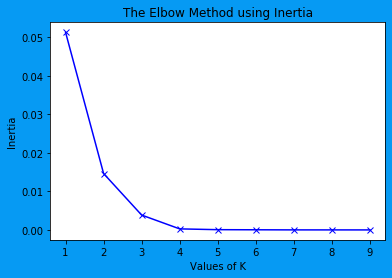

In [94]:
# Making a dataframe for clustering
Chennai_clustering = Chennai_restaurant.drop(["Area"], 1)

# Initialising a list to hold the measures for each 'K'
inertias = []
# Filling in the list
for k in range(1,10):
  k_op = KMeans(n_clusters=k, random_state=0).fit(Chennai_clustering)
  inertias.append(k_op.inertia_)
    
# Plotting a figure illustrating the performance against the values of 'K'
K = range(1,10)
fig = plt.figure()
fig.patch.set_facecolor('xkcd:azure')
plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show() 

In [98]:
# Setting optimum value to a variable
kclusters = 4

# Running k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Chennai_clustering)

# Checking cluster labels generated
print(kmeans.labels_[0:10])


# Creating a new dataframe that will include the cluster labels
Chennai_merged = Chennai_restaurants.copy()

# Adding cluster labels to the dataframe
Chennai_merged["Cluster Labels"] = kmeans.labels_


[0 1 0 0 1 0 0 0 0 0]


In [103]:
# Creating a dataframe merging initial data with this new data
Chennai_merged = Chennai_merged.join(chennai_df.set_index("areas"), on="Area")
# Checking the size of the dataframe
print(Chennai_merged.shape)
# Having a look at the dataframe
Chennai_merged.head()

(148, 6)


,Area,Italian Restaurant,Cluster Labels,zones,latitudes,longitudes
0,Adambakkam,0.000000,0,Zone 13 Adyar,12.9822,80.2091
1,Adyar,0.034483,1,Zone 13 Adyar,13.0064,80.2578
2,Alandur,0.000000,0,Thillai Ganga Nagar,12.9944,80.1943
3,Alapakkam,0.000000,0,Zone 11 Valasaravakkam,13.0499,80.1654
4,Alwarpet,0.047619,1,Zone 9 Teynampet,13.0339,80.2545


We segregate the venues into four clusters and add the cluster labels to our final dataframe. We examine the clusters by plotting them onto a map.
Following are the color codes for each cluster:

Cluster 0: Green

Cluster 1: Violet

Cluster 2: Yellow

Cluster 3: Grey

Following are the concentrations of restaurants in each cluster:
Cluster 0 (Green): Least

Cluster 1 (Violet): High

Cluster 2 (Yellow): Moderate

Cluster 3 (Grey): Highest

In [104]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# Setting color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.Dark2(np.linspace(0, 1, len(ys)))
colorbar = [colors.rgb2hex(i) for i in colors_array]

# Adding markers to the map
markers_colors = []
for lat, lon, poi, cluster, location in zip(Chennai_merged['latitudes'], Chennai_merged['longitudes'], Chennai_merged['Area'], Chennai_merged['Cluster Labels'], Chennai_merged['zones']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        tooltip = str(poi)+', '+location,
        color=colorbar[cluster],
        fill=True,
        fill_color=colorbar[cluster],
        fill_opacity=0.6).add_to(map_clusters)

In [118]:
map_clusters

In [107]:
 # Setting an option to get all the rows for the dataframe
 pd.set_option('display.max_rows', Chennai_merged.shape[0]+1)

In [113]:
# Cluster 0
Chennai_merged[Chennai_merged['Cluster Labels'] == 0].head(5)

,Area,Italian Restaurant,Cluster Labels,zones,latitudes,longitudes
0,Adambakkam,0.0,0,Zone 13 Adyar,12.9822,80.2091
2,Alandur,0.0,0,Thillai Ganga Nagar,12.9944,80.1943
3,Alapakkam,0.0,0,Zone 11 Valasaravakkam,13.0499,80.1654
5,Alwarthirunagar,0.0,0,Zone 11 Valasaravakkam,13.0475,80.1837
6,Ambattur,0.0,0,Zone 7 Ambattur,13.1194,80.1508


In [110]:
# Cluster 1
Chennai_merged[Chennai_merged['Cluster Labels'] == 1]

,Area,Italian Restaurant,Cluster Labels,zones,latitudes,longitudes
1,Adyar,0.034483,1,Zone 13 Adyar,13.0064,80.2578
4,Alwarpet,0.047619,1,Zone 9 Teynampet,13.0339,80.2545
14,Besant Nagar,0.032258,1,Zone 13 Adyar,12.9997,80.2682
31,Guindy,0.040000,1,Zone 13 Adyar,13.0087,80.2204
73,Mount Road,0.047619,1,Lotus Colony,13.0338,80.2445
137,Vadapalani,0.037037,1,Vadapalani Flyover,13.0509,80.2121
141,Velachery,0.034483,1,Zone 13 Adyar,12.9802,80.2229


In [111]:
# Cluster 2
Chennai_merged[Chennai_merged['Cluster Labels'] == 2]

,Area,Italian Restaurant,Cluster Labels,zones,latitudes,longitudes
49,Kottivakkam,0.166667,2,Zone 14 Perungudi,12.9705,80.2615


In [112]:
# Cluster 3
Chennai_merged[Chennai_merged['Cluster Labels'] == 3]

,Area,Italian Restaurant,Cluster Labels,zones,latitudes,longitudes
87,Palavakkam,0.090909,3,Zone 14 Perungudi,12.96,80.256
124,Teynampet,0.083333,3,Zone 9 Teynampet,13.0443,80.2498


## Conclusion

### We got the winner for : Kottivakkam	
Kottivakkam is a locality in the south of Chennai in Chennai district in the Indian state of Tamil Nadu. Kottivakkam lies in Yellow area which has moderate number of Italian Restaurants. 

We might ask why go for moderately concentrated place instead of going for areas where no Italian Restaurants are found. The reason for this is people in green area may not prefer Italian restaurants and may not be even aware of Italian cusines. Also people  in grey area will have too many Italian restaurants to choose from and our entity may go unnoticed during the process. 





## Recommeded
Our targeted location is surrounded by places where High concentration of Italian restaurants present in the area but kottivakam the concentration is moderate. This strategy is based on Nash equilibrium. 